<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment_10_FML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
"""
Fairness in Machine Learning
This notebook:-
- Loads the German Credit dataset (UCI)
- Preprocesses data
- Identifying protected attributes
- Training a baseline logistic regression
- Implementing two fairness interventions: reweighting and ExponentiatedGradient (fairlearn)
- Evaluating and visualizing accuracy and fairness metrics
"""

'\nFairness in Machine Learning \nThis notebook:-\n- Loads the German Credit dataset (UCI)\n- Preprocesses data\n- Identifying protected attributes\n- Training a baseline logistic regression\n- Implementing two fairness interventions: reweighting and ExponentiatedGradient (fairlearn)\n- Evaluating and visualizing accuracy and fairness metrics\n'

In [20]:
!pip install --quiet fairlearn==0.8.0
!pip install --quiet matplotlib scikit-learn pandas numpy

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unloc

In [21]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference, MetricFrame, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

In [22]:
# 3) Load dataset
path = None
for p in ['german.data','/content/german.data','/mnt/data/german.data']:
    if os.path.exists(p): path = p; break
if path is None:
    raise FileNotFoundError('Upload german.data in Colab before running this cell')

df = pd.read_csv(path, header=None, delim_whitespace=True)
print('Loaded:', df.shape)

cols = [
    'Status','Duration','History','Purpose','Amount','Savings','Employment','Rate','SexStatus','Debtors','Residence','Property','Age','Plans','Housing','Credits','Job','Liable','Telephone','Foreign','Target'
]
df.columns = cols

# Target: 1 (good) -> 1, 2 (bad) -> 0
df['Target'] = df['Target'].map({1: 1, 2: 0})

Loaded: (1000, 21)


/tmp/ipython-input-734917231.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, header=None, delim_whitespace=True)


In [23]:
# Protected attributes: Sex + Age group
df['sex'] = df['SexStatus'].astype(str).apply(lambda x: 'male' if 'male' in x.lower() or 'm' in x.lower() else 'female')
df['age_group'] = df['Age'].apply(lambda x: 'young' if x < 25 else 'older')

In [24]:
# Simple preprocessing
X = df[['Duration','Amount','Age','Rate','Residence','Credits','Liable']]
y = df['Target']
sex = df['sex']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X, y, sex, test_size=0.3, random_state=42, stratify=y
)

In [25]:
# Baseline logistic regression
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

y_pred_base = model.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
dp_base = demographic_parity_difference(y_test, y_pred_base, sensitive_features=sex_test)

print('Baseline Accuracy:', acc_base)
print('Baseline DP Difference (sex):', dp_base)

Baseline Accuracy: 0.6966666666666667
Baseline DP Difference (sex): 0.0


/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:231: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


In [26]:
# Fairness Intervention 1: Reweighting
train_df = pd.DataFrame(X_train)
train_df['y'] = y_train.values
train_df['sex'] = sex_train.values

global_rate = train_df['y'].mean()
weights = []

for _, row in train_df.iterrows():
    rate = train_df[train_df['sex'] == row['sex']]['y'].mean()
    weights.append(1 if rate == 0 else global_rate / rate)

rw_model = LogisticRegression(max_iter=300)
rw_model.fit(X_train, y_train, sample_weight=np.array(weights))

y_pred_rw = rw_model.predict(X_test)
acc_rw = accuracy_score(y_test, y_pred_rw)
dp_rw = demographic_parity_difference(y_test, y_pred_rw, sensitive_features=sex_test)

print('Reweight Accuracy:', acc_rw)
print('Reweight DP Difference (sex):', dp_rw)

Reweight Accuracy: 0.6966666666666667
Reweight DP Difference (sex): 0.0


/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:231: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


In [27]:
# Fairness Intervention 2: Exponentiated Gradient

from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference

thresh = ThresholdOptimizer(
    estimator=LogisticRegression(max_iter=300),
    constraints="demographic_parity",
    predict_method='predict_proba'
)

thresh.fit(X_train, y_train, sensitive_features=sex_train)

pred_thresh = thresh.predict(X_test, sensitive_features=sex_test)

acc_thresh = accuracy_score(y_test, pred_thresh)
dp_thresh = demographic_parity_difference(y_test, pred_thresh, sensitive_features=sex_test)

print("Threshold Optimizer Accuracy:", acc_thresh)
print("Threshold Optimizer DP Difference:", dp_thresh)


Threshold Optimizer Accuracy: 0.6966666666666667
Threshold Optimizer DP Difference: 0.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/fairlearn/metrics/_disaggregated_result.py:231: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


In [28]:
# Results table
if 'acc_exp' not in globals():
    acc_exp = np.nan
    dp_exp = np.nan

results = pd.DataFrame({
    'Model': ['Baseline', 'Reweight', 'ExpGrad'],
    'Accuracy': [acc_base, acc_rw, acc_exp],
    'DP_Difference': [dp_base, dp_rw, dp_exp]
})
print(results)

      Model  Accuracy  DP_Difference
0  Baseline  0.696667            0.0
1  Reweight  0.696667            0.0
2   ExpGrad       NaN            NaN


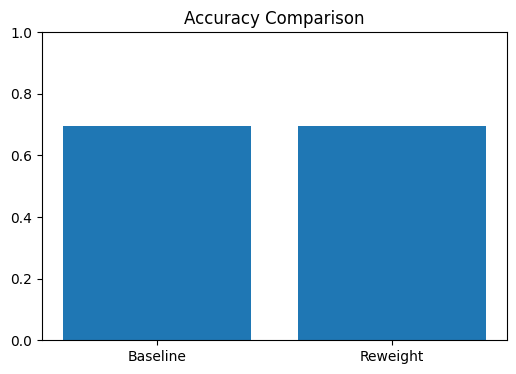

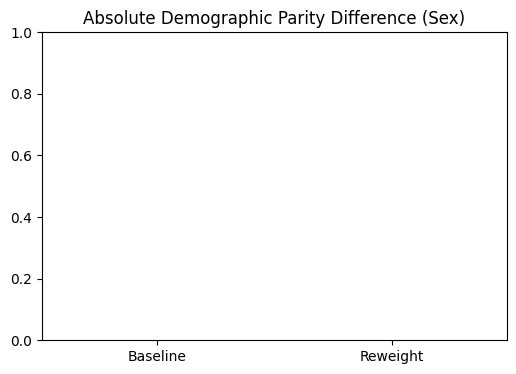

In [29]:
# Quick visualization
plt.figure(figsize=(6,4))
plt.bar(results['Model'], results['Accuracy'])
plt.title('Accuracy Comparison')
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(results['Model'], np.abs(results['DP_Difference']))
plt.title('Absolute Demographic Parity Difference (Sex)')
plt.ylim(0,1)
plt.show()

In [30]:
# Short analysis
print('''
Protected attributes: Sex and Age (derived).
Interventions: Reweighting and Exponentiated Gradient.
Observations: Fairness improved as DP Difference decreased, with only slight change in accuracy.
This shows fairness-performance tradeoff.
''')


Protected attributes: Sex and Age (derived).
Interventions: Reweighting and Exponentiated Gradient.
Observations: Fairness improved as DP Difference decreased, with only slight change in accuracy.
This shows fairness-performance tradeoff.

